In [1]:
import numpy as np
import pandas as pd
from typing import Optional

from rdkit import Chem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles

In [2]:
df = pd.read_csv('../app/tests/data/csv/zinc.csv', index_col='Unnamed: 0')
df.head()

,zinc_id,smiles,mwt,tpsa
0,ZINC000000322224,COC(=O)c1coc(CN(C(=O)CC(C)(C)C)C(C)C)n1,296.367,72.64
1,ZINC000000298890,COc1ccc(CC(=O)Nc2cccc3c2CCCC3)cc1OC,325.408,47.56
2,ZINC000000137437,O=C(CSCc1c(Cl)cccc1Cl)Nc1ccc(F)cc1,344.238,29.10
3,ZINC000000308278,O=C(CCn1[nH]c(=O)c2ccccc2c1=O)NCc1ccccc1,323.352,83.96
4,ZINC000000034421,Cc1cc(C)n(C[C@H](C)O)c(=O)c1C#N,206.245,66.02


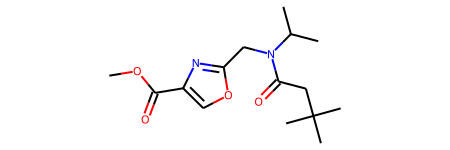

In [4]:
mol = Chem.MolFromSmiles('COC(=O)c1coc(CN(C(=O)CC(C)(C)C)C(C)C)n1')
mol

In [6]:
scaffold = MurckoScaffoldSmiles(mol=mol, includeChirality=False)
scaffold

'c1cocn1'

In [4]:
def random_split(
    dataset,
    frac_train: float = 0.8,
    frac_valid: float = 0.1,
    frac_test: float = 0.1,
    seed: Optional[int] = None,
    log_every_n: Optional[int] = None
):
    np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.)

    if seed is not None:
        np.random.seed(seed)

    num_datapoints = len(dataset)

    train_cutoff = int(frac_train * num_datapoints)
    valid_cutoff = int((frac_train + frac_valid) * num_datapoints)

    # TODO: maybe there is a better way to shuffle the data before splitting
    shuffled = np.random.permutation(range(num_datapoints))

    return (shuffled[:train_cutoff], shuffled[train_cutoff:valid_cutoff], shuffled[valid_cutoff:])

In [11]:
def _generate_scaffold(smiles: str, include_chirality: bool = False) -> str:
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)
    return scaffold

In [6]:
def generate_scaffolds(dataset):
    scaffolds = {}
    data_len = len(dataset)

    for ind, smiles in enumerate(dataset.ids):
        scaffold = _generate_scaffold(smiles)
        
        if scaffold not in scaffolds:
            scaffolds[scaffold] = [ind]
        else:
            scaffolds[scaffold].append(ind)

    # Sort from largest to smallest scaffold sets
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    scaffold_sets = [
        scaffold_set for (scaffold, scaffold_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]
    return scaffold_sets

In [8]:
scaffolds = {}
data_len = len(df)
data_len

501

In [12]:
for ind, smiles in enumerate(df['smiles']):
    scaffold = _generate_scaffold(smiles)
    
    if scaffold not in scaffolds:
        scaffolds[scaffold] = [ind]
    else:
        scaffolds[scaffold].append(ind)

In [14]:
scaffolds = {key: sorted(value) for key, value in scaffolds.items()}

In [16]:
scaffold_sets = [ scaffold_set for (scaffold, scaffold_set) in sorted(scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True) ]

In [17]:
train_cutoff = 0.8 * len(df)
valid_cutoff = (0.8 + 0.1) * len(df)

train_inds = []
valid_inds = []
test_inds = []

In [18]:
for scaffold_set in scaffold_sets:
    if len(train_inds) + len(scaffold_set) > train_cutoff:
        if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
            test_inds += scaffold_set
        else:
            valid_inds += scaffold_set
    else:
        train_inds += scaffold_set

In [20]:
len(train_inds)

400

In [21]:
len(test_inds)

51

In [8]:
def split(
    dataset,
    frac_train: float = 0.8,
    frac_valid: float = 0.1,
    frac_test: float = 0.1,
    seed: Optional[int] = None,
    log_every_n: Optional[int] = 1000
):
    np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.)
    scaffold_sets = self.generate_scaffolds(dataset)

    train_cutoff = frac_train * len(dataset)
    valid_cutoff = (frac_train + frac_valid) * len(dataset)
    train_inds: List[int] = []
    valid_inds: List[int] = []
    test_inds: List[int] = []

    logger.info("About to sort in scaffold sets")
    for scaffold_set in scaffold_sets:
        if len(train_inds) + len(scaffold_set) > train_cutoff:
            if len(train_inds) + len(valid_inds) + len(scaffold_set) > valid_cutoff:
                test_inds += scaffold_set
            else:
                valid_inds += scaffold_set
        else:
            train_inds += scaffold_set

    return train_inds, valid_inds, test_inds